# A Bayesian network for Heart attacks prevention
### Exam: Foundamentals of Artificial Intelligence and Knowledge Representation - Module 3
### Student: Agostino Aiezzo - 982514 - agostino.aiezzo@studio.unibo.it


## Introduction

The aim of this project is, in fact, to build a probabilistic model which tries to understand the relationships among different causes for heart attack cases and which of them are the most relevant. For this reason, the dataset provided by UCI and created by different medical and hospital research institutes is used. It provides a lot of attributes, but all the experiments tend to use a subset of 14 of them. Here they are below:

- age : Age of the patient
- sex : Sex of the patient (0 = female, 1 = male)
- cp : Chest pain, 4 possible values (typical angina, atypical angina, non-anginal pain, asymptomatic)
- trestbps : Resting blood pressure
- chol : Serum cholestoral in mg/dl
- fbs : Fasting blood sugar > 120 mg/dl, 2 possible values (0 = False, 1 = True)
- restecg : Resting electrocardiographic results, 3 possible values (normal, ST-T wave
abnormality, probable or definite left ventricular hypertrophy by Estes's criteria)
- thalach : Maximum heart rate achieved
- exang : Execercise induced angina (0=No, 1=Yes)
- oldpeak : ST depression induced by exercise relative to rest
- slope : the slope of the peak exercise ST segment, 3 possible values (upsloping, flat,
downsloping)
- ca : Number of major vessels (0-3) colored by flourosopy
- thal: Thalassemia, 3 possible values (normal, fixed defect, reversable defect)
- target : Probability of heart attach, 2 possible values (0 = No, 1=Yes)

Fortunately, there are no missing values. In any case, some data processing needs to be done in order to obtain many advantages during model construction.

## Step 1: data bucketization

The main reasons for data to be prepared are to obtain a more compact and comprehensive model. In this way, efficiency and low computational effort are achieved. 

In [1]:
'''All the libraries needed during the execution of the program'''

import pandas as pd
import numpy as np
import networkx as nx
from pgmpy.estimators import BicScore, HillClimbSearch, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy. inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

In [2]:
'''All the functions specifically written for the correct execution of the program'''

def draw_bayesian_network(nodes, edges): #It is used for drawing bayesian networks (since they are
                                        # directed acyclic graph or DAG, networkx library is provided).
    graph = nx.DiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    options = {
        'node_size': 700,
        'width': 2,
        'arrowstyle': '<|-',
        'arrowsize': 15,
        'with_labels': True,
        'arrows': True
    }
    
    nx.draw_shell(graph, **options)


def lw_sampling_infer(model, query, value, evidence, size=500): #compute an inference using likelihood 
                                                                #weighting, returning the calculated 
                                                                #probability and the generated samples

    evidences = []
    for key, v in evidence.items():
        evidences.append(State(key,v))
    
    sampler = BayesianModelSampling(model)
    samples = sampler.likelihood_weighted_sample(size=size,evidence=evidences)
    
    containing = (samples[samples[query]==value])['_weight'].sum()
    total = samples['_weight'].sum()
    
    return containing / total, samples

Let's have a look to the dataset.

In [3]:
url = 'heart.csv'
df = pd.read_csv(url, sep = ',')

df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In this case, what is necessary to do is to recast some of the attributes of the dataset through bucketization, that is the grouping of many values into a series of categories identified by specific names.
As you can see, there are many paramaters that need to be bucketized such as 'age', 'trestbps', 'chol', 'oldpeak', etc. So, these and other columns are going to be considered, but, for safety, it's better to work on a copy of the data.

In [4]:
df_copy = df.copy()

What it's possible to do for the 'age' column is to consider, for example, 5 possible categories (the ones below). Even if not all of them have a match, it is worth it for future extensions of the dataset with new rows.

In [5]:
df_copy['age'] = pd.cut(x=df_copy['age'],
                       bins=[0,10,18,30,65,120],
                       labels=['Baby','Minor','Young','Adult','Old'])
df_copy['age'].unique()

['Adult', 'Old', 'Young']
Categories (3, object): ['Young' < 'Adult' < 'Old']

Something similar is done the for 'trestbps' column.

In [6]:
df_copy['trestbps'] = pd.cut(x=df_copy['trestbps'],
                       bins=[0,50,90,130,250,500],
                       labels=['Very Low','Low','Medium','High','Very High'])
df_copy['trestbps'].unique()

['High', 'Medium']
Categories (2, object): ['Medium' < 'High']

In this case, for the sake of realism, the 'chol' column has been bucketized by using only 2 possible values. In particular, 'True' is the case in which the blood cholesterol is above 200 mg/dl; 'False' on the countrary case.

In [7]:
df_copy['chol'] = np.where((df_copy['chol'] > 200), True, #se supera i 200
                           np.where((df_copy['chol'] <= 200), False, 'No Change'))
df_copy['chol'].unique()

array(['True', 'False'], dtype=object)

Initially, the 'thalach' column, as well as the 'chol' one, was bucketized with either 'True' or 'False' values. However, in this way some relations in the Bayesian network were not expressed probably because many shades of information were lost in the process. So, for this reason the number of possible categories has been expanded and thus new links among attributes were generated.

In [8]:
df_copy['thalach'] = pd.cut(x=df_copy['thalach'],
                       bins=[0,90,130,500],
                       labels=['Low','Medium','High'])
df_copy['thalach'].unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']

In conclusion, also the 'oldpeak' column has been bucketized as usual. The only drawback encountered, in this case, was about some missing values, but they have been simply solved by filling them with the correspondent category.  

In [9]:
df_copy['oldpeak'] = pd.cut(x=df_copy['oldpeak'],
                       bins=[0.,1.,3.,10.],
                       labels=['Small','Mid','Big'])
df_copy['oldpeak'] = df_copy['oldpeak'].fillna('Small')
df_copy['oldpeak'].unique()

['Mid', 'Big', 'Small']
Categories (3, object): ['Small' < 'Mid' < 'Big']

Here below there's the final result. As you can notice, the dataset is not only ready to be used to build the probabilistic model, but it is also more human-readable and cleaned.

In [10]:
df_copy

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,Adult,1,3,High,True,1,0,High,0,Mid,0,0,1,1
1,Adult,1,2,Medium,True,0,1,High,0,Big,0,0,2,1
2,Adult,0,1,Medium,True,0,0,High,0,Mid,2,0,2,1
3,Adult,1,1,Medium,True,0,1,High,0,Small,2,0,2,1
4,Adult,0,0,Medium,True,0,1,High,1,Small,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Adult,0,0,High,True,0,1,Medium,1,Small,1,0,3,0
299,Adult,1,3,Medium,True,0,1,High,0,Mid,1,0,3,0
300,Old,1,0,High,False,1,1,High,0,Big,1,2,3,0
301,Adult,1,0,Medium,False,0,1,Medium,1,Mid,1,1,3,0


## Step 2: Building the Bayesian network

After the elaboration of the data, it's possible to build a first instance of the Bayesian network. In fact many attempts need to be done before obtaining the best model. In particular, some considerations need to be taken into account in order to have an efficient model.

To build the Bayesian network, first of all, a scoring method needs to be fixed. In this way, it's possible to understand how well a model is able to describe the given data set. The pgmpy library provides the 'BicScore' class which is the one used below here because it is able to avoid overfitting unlike other methods like 'K2Score' and 'BDeuScore'. In fact, these latter seem to not care about overfitting and as a consequence the obtained graphs are quite different from the one provided by the 'BicScore' object (they are characterized by more connections).

In [11]:
scoring = BicScore(df_copy) 

For what regards the algorithm used for searching the best graph (always according to the score method), the 'HillClimbSearch' class is considered. Also in this case, other possibilities exist like for example 'PC' or 'ExhaustiveSearch'. However, this latter, for example, is not feasible if there are more than 6 nodes (attributes).

  8%|██████▌                                                                           | 8/100 [00:02<00:25,  3.59it/s]


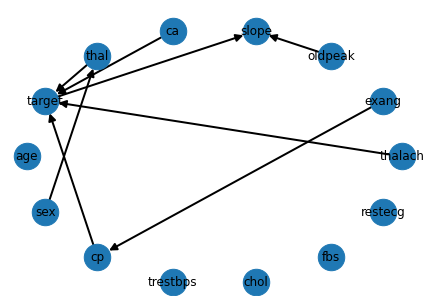

In [12]:
hcs = HillClimbSearch(df_copy) 
first_model = hcs.estimate(max_iter=100, scoring_method = scoring)

draw_bayesian_network(df_copy.columns, first_model.edges())

Observing the first model obtained allows to deduce something important: there are some attributes which seem to not influence the network. It's possible to confirm this possibility if the network with the not bucketized parameters is computed. In fact, the two graphs turn out to be identical. As a consequence, it's possible to discard the attributes with no connections in order to have a leaner and, hypothetically, a more efficient graph.

In [13]:
data = df_copy.copy()
data.drop(['age', 'trestbps','chol','fbs','restecg'], axis=1, inplace=True) #Discard the attributes
                                                                            #with no connections

data = data.rename(columns={'sex':'SEX','cp':'C_PAIN','thalach':'MAX_HR', #Renaming for the sake of 
                                                                            #clarity
                            'exang':'ANGINA','oldpeak':'ST_DEPR','slope':'SLOPE_ST',
                           'ca':'MAX_V','thal':'THAL','target':'H_ATTACK'})
data

,SEX,C_PAIN,MAX_HR,ANGINA,ST_DEPR,SLOPE_ST,MAX_V,THAL,H_ATTACK
0,1,3,High,0,Mid,0,0,1,1
1,1,2,High,0,Big,0,0,2,1
2,0,1,High,0,Mid,2,0,2,1
3,1,1,High,0,Small,2,0,2,1
4,0,0,High,1,Small,2,0,2,1
...,...,...,...,...,...,...,...,...,...
298,0,0,Medium,1,Small,1,0,3,0
299,1,3,High,0,Mid,1,0,3,0
300,1,0,High,0,Big,1,2,3,0
301,1,0,Medium,1,Mid,1,1,3,0


Based on the cleaned data, the new Bayesian network is created.

  8%|██████▌                                                                           | 8/100 [00:00<00:10,  8.38it/s]


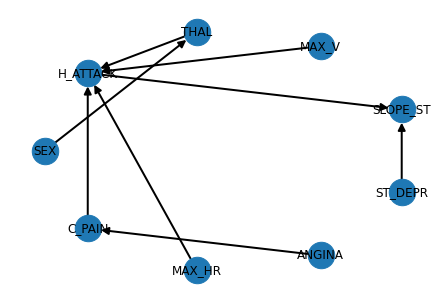

In [14]:
scoring = BicScore(data)

hcs = HillClimbSearch(data)
final_model = hcs.estimate(max_iter=100, scoring_method = scoring)

draw_bayesian_network(data.columns, final_model.edges())


This is the final result. Just to be clear, the direction of the relations needs to be considered as something like ' A is influenced by B ' and not like 'A influences B' as in fact it normally is with Bayesian networks.

So, the last step now is to compute the CPDs that are the probabilities for each of the attribute involved in the network. To do that, of course, each instance of the dataset and a 'BayesianEstimator' object are taken into account. Another possibility was to adopt a 'MaximumLikelihoodEstimator' but, after some attempts, it is less comfortable to use.

In [15]:
bayesian_model = BayesianModel(final_model.edges())
bayesian_model.fit(data, estimator = BayesianEstimator, prior_type="BDeu")

bayesian_model.check_model()

True

Let's have a look to the CPDs

In [16]:
for cpd in bayesian_model.get_cpds():
    print('CPT of', cpd.variable)
    print(cpd,'\n')

CPT of C_PAIN
+-----------+----------------------+---------------------+
| H_ATTACK  | H_ATTACK(0)          | H_ATTACK(1)         |
+-----------+----------------------+---------------------+
| C_PAIN(0) | 0.744661921708185    | 0.23656716417910448 |
+-----------+----------------------+---------------------+
| C_PAIN(1) | 0.06850533807829182  | 0.24850746268656718 |
+-----------+----------------------+---------------------+
| C_PAIN(2) | 0.13256227758007116  | 0.41567164179104477 |
+-----------+----------------------+---------------------+
| C_PAIN(3) | 0.054270462633451956 | 0.09925373134328358 |
+-----------+----------------------+---------------------+ 

CPT of ANGINA
+-----------+--------------------+---------------------+---------------------+---------------------+
| C_PAIN    | C_PAIN(0)          | C_PAIN(1)           | C_PAIN(2)           | C_PAIN(3)           |
+-----------+--------------------+---------------------+---------------------+---------------------+
| ANGINA(0) | 0.44

## Step 3: structural analysis and inferring

Once the CPDs are avaiable, it's staightforward to start to deduce and discover interesting patterns. In particular, it's possible to conduct a structural analysis of the network. For example, it is interesting to know about conditional independencies give certain evidences.

In [17]:
bayesian_model.get_independencies().get_assertions()[201:211]

[(C_PAIN ⟂ ST_DEPR | ANGINA, SLOPE_ST, MAX_HR),
 (C_PAIN ⟂ MAX_V, SEX, THAL, ST_DEPR, MAX_HR | ANGINA, H_ATTACK, SLOPE_ST),
 (C_PAIN ⟂ ST_DEPR | ANGINA, MAX_V, SLOPE_ST),
 (C_PAIN ⟂ ST_DEPR | ANGINA, SLOPE_ST, SEX),
 (C_PAIN ⟂ ST_DEPR, SEX | ANGINA, SLOPE_ST, THAL),
 (C_PAIN ⟂ THAL, MAX_V, MAX_HR, SEX | ST_DEPR, H_ATTACK, SLOPE_ST),
 (C_PAIN ⟂ SEX | ST_DEPR, SLOPE_ST, THAL),
 (C_PAIN ⟂ ST_DEPR, MAX_V, THAL, SEX | H_ATTACK, SLOPE_ST, MAX_HR),
 (C_PAIN ⟂ ST_DEPR | MAX_V, SLOPE_ST, MAX_HR),
 (C_PAIN ⟂ ST_DEPR | SLOPE_ST, MAX_HR, SEX)]

In addition, what is possible to do is to compute some exact inference through the 'VariableElimination' method. Trivially, it's possible to know, for example, who has the highest probability, between a man and a woman, to get an heart attack.

In [18]:
inference = VariableElimination(bayesian_model)

f_heart_attack = inference.query(show_progress=True,variables=['H_ATTACK'], evidence={
                                                                        'SEX':0
                                                                           })
m_heart_attack = inference.query(show_progress=True,variables=['H_ATTACK'], evidence={
                                                                        'SEX':1
                                                                           })

print('Probability to get an heart attack if I am a male\n', m_heart_attack)
print('Probability to get an heart attack if I am a female\n', f_heart_attack)

Eliminating: THAL: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

Probability to get an heart attack if I am a male
 +-------------+-----------------+
| H_ATTACK    |   phi(H_ATTACK) |
+=============+=================+
| H_ATTACK(0) |          0.5219 |
+-------------+-----------------+
| H_ATTACK(1) |          0.4781 |
+-------------+-----------------+
Probability to get an heart attack if I am a female
 +-------------+-----------------+
| H_ATTACK    |   phi(H_ATTACK) |
+=============+=================+
| H_ATTACK(0) |          0.3163 |
+-------------+-----------------+
| H_ATTACK(1) |          0.6837 |
+-------------+-----------------+


It turns out that females have higher chances.
Another interesting example is to try to understand how much an angina after exercise can increase (or decrease) the probability to get an heart attack.

In [19]:
angina_h_attack = inference.query(show_progress=True,variables=['ANGINA'], evidence={
                                                                        'H_ATTACK':1
                                                                           })

print('Probability to get an heart attack caused by angina after an exercise\n', angina_h_attack)



Finding Elimination Order: :   0%|                                                               | 0/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Eliminating: C_PAIN: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Probability to get an heart attack caused by angina after an exercise
 +-----------+---------------+
| ANGINA    |   phi(ANGINA) |
+===========+===============+
| ANGINA(0) |        0.7717 |
+-----------+---------------+
| ANGINA(1) |        0.2283 |
+-----------+---------------+


It looks like that angina is not sufficient to define the occurence of an heart attack.
What about if fixed defect for thalassemia and an atypical chest pain are considered? What is the probability for heart attack in such a case?

In [20]:
thal_cp_h_attack = inference.query(show_progress=True,variables=['H_ATTACK'], evidence={
                                                                        'THAL':1,
                                                                        'C_PAIN':1
                                                                           })


print('Probability to get an heart attack if I have fixed thalassemia and and atypical chest pain\n', thal_cp_h_attack)




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|                                                               | 0/1 [00:00<?, ?it/s]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


Eliminating: SLOPE_ST: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.99it/s]

Probability to get an heart attack if I have fixed thalassemia and and atypical chest pain
 +-------------+-----------------+
| H_ATTACK    |   phi(H_ATTACK) |
+=============+=================+
| H_ATTACK(0) |          0.3444 |
+-------------+-----------------+
| H_ATTACK(1) |          0.6556 |
+-------------+-----------------+


Of course the probability of getting troubles is high.

However, in some cases, the computed network is too big to estimate exact inferences because the computational effort is too heavy. So, in alternative, it's possible to compute an approximation of these probabilities by using tecniques that generate random samples and thus the probability of the query (that is actually how probability is calculated in real world experiment).

In particular, Rejection sampling algorithm is implemented here since it is one the simplest: it generates only those samples that have certain evidences and discard the others. However, likelihood weighting variant is preferable since it is smarter: it assigns a weight to each generated sample.

In [21]:
query = 'H_ATTACK'
value = 1
evidence = {
    'THAL': 1,
    'C_PAIN':1   
}

In [22]:
lw_prob, samples = lw_sampling_infer(bayesian_model,
                                    query=query,
                                    value=value,
                                    evidence=evidence)
print('Approximate probability of getting an heart attack with fixed thalassemia and atypical chest pain:',
      lw_prob)

Generating for node: ST_DEPR: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 374.59it/s]


Approximate probability of getting an heart attack with fixed thalassemia and atypical chest pain: 0.6484439356154008


## Conclusions

Surely, what is possible to deduce is that Bayesian networks are powerful tools in medical contexts because they are simple to use and allow to infer interesting insights in an environmente which is characterized by many other factors and variations. Of course, the model built in this project is not realiable since many approximation and inaccuracies were committed, but the potential can be expressed with the help of an expert. In addition, other kinds of structural analysis might be thoughtful like, for example, active trails, Markov blankets, and so on.